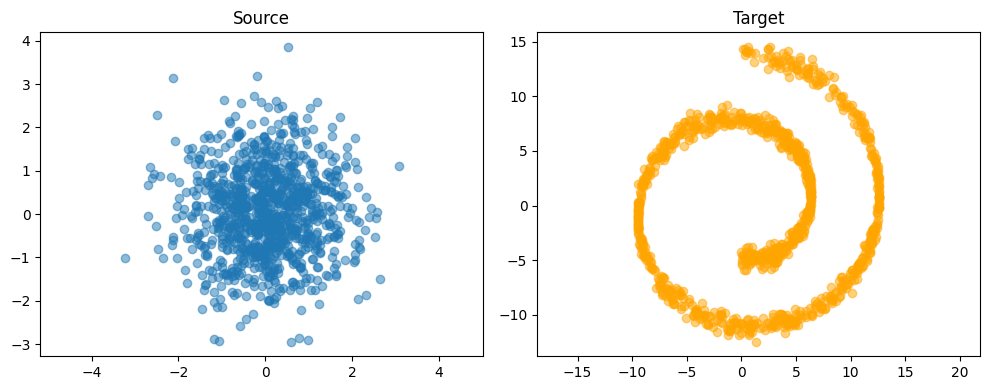

In [36]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchdiffeq import odeint
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

# 2. Data Generation (shared)


def sample_standard_gaussian(n_samples=1000):
    return np.random.randn(n_samples, 2).astype(np.float32)

def sample_swiss_roll(n_samples=1000):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(n_samples))
    x = t * np.cos(t)
    y = t * np.sin(t)
    noise = 0.5 * np.random.randn(n_samples)
    return np.stack([x, y + noise], axis=1).astype(np.float32)

def sample_star_distribution(n_samples=1000, arms=5):
    angles = np.random.choice(np.linspace(0, 2*np.pi, arms, endpoint=False), n_samples)
    r = 2 + 0.3 * np.random.randn(n_samples)
    x = r * np.cos(angles) + 0.1 * np.random.randn(n_samples)
    y = r * np.sin(angles) + 0.1 * np.random.randn(n_samples)
    return np.stack([x, y], axis=1).astype(np.float32)

def sample_gaussian_mixture(n_samples=1000):
    centers = [np.array([-2.0, 0.0]), np.array([2.0, 0.0])]
    samples = []
    for _ in range(n_samples):
        center = centers[np.random.choice([0, 1])]
        noise = np.random.randn(2) * 0.2
        samples.append(center + noise)
    return np.array(samples, dtype=np.float32)

source_np = sample_standard_gaussian(1000)
target_np = sample_swiss_roll(1000)
# target_np = sample_gaussian_mixture(1000)
# source_np = sample_swiss_roll(1000)
# target_np = sample_standard_gaussian(1000)

# Visualize source and target samples
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(source_np[:, 0], source_np[:, 1], alpha=0.5)
plt.title("Source")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.scatter(target_np[:, 0], target_np[:, 1], alpha=0.5, color='orange')
plt.title("Target")
plt.axis("equal")

plt.tight_layout()
plt.show()

In [37]:
# Re-import after kernel reset
from scipy.linalg import sqrtm
from scipy.stats import wasserstein_distance

# Redefine metrics
def frechet_distance(X_gen, X_real):
    mu_gen = np.mean(X_gen, axis=0)
    mu_real = np.mean(X_real, axis=0)
    cov_gen = np.cov(X_gen, rowvar=False)
    cov_real = np.cov(X_real, rowvar=False)
    covmean = sqrtm(cov_gen @ cov_real)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu_gen - mu_real
    return diff @ diff + np.trace(cov_gen + cov_real - 2 * covmean)

def wasserstein_2d(X_gen, X_real):
    d1 = wasserstein_distance(X_gen[:, 0], X_real[:, 0])
    d2 = wasserstein_distance(X_gen[:, 1], X_real[:, 1])
    return (d1 + d2) / 2

# def plot_wasserstein_over_time(rf_trajectories, cnf_trajectory, target_np, t_vals):
#     rf_ws = []
#     cnf_ws = []
#     for i in range(len(t_vals)):
#         rf_ws.append(wasserstein_2d(rf_trajectories[i], target_np))
#         cnf_ws.append(wasserstein_2d(cnf_trajectory[i].detach().numpy(), target_np))

#     plt.figure(figsize=(8, 4))
#     plt.plot(t_vals.numpy(), rf_ws, label="RF vs Target", color="green")
#     plt.plot(t_vals.numpy(), cnf_ws, label="CNF vs Target", color="orange")
#     plt.xlabel("Time t")
#     plt.ylabel("Wasserstein Distance")
#     plt.title("Trajectory-wise Wasserstein Distance to Target")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [38]:
# Convert to Torch tensors
source_data = torch.tensor(source_np)
target_data = torch.tensor(target_np)
dataset = TensorDataset(source_data, target_data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# 3. Rectified Flow (RF) Network
class RFNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)

# 4. CNF (ODE-based Flow)
class CNFNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)



# 6. Visualization
def sample_from_cnf(model, n_samples=1000):
    model.eval()
    with torch.no_grad():
        z0 = torch.randn(n_samples, 2)

        def odefunc(t, x):
            return model(t, x)

        t0, t1 = 0.0, 1.0
        t_vals = torch.tensor([t0, t1], dtype=z0.dtype, device=z0.device)
        out = odeint(odefunc, z0, t_vals)
        xT = out[1]  # take the final result
        return xT
            
def visualize_cnf(model, source_data, t_vals=None, target_np=None, save_path = "cnf_trajectory.png"):
    """
    Visualize CNF trajectories and generated samples.
    Args:
        model: trained CNF model
        source_data: Tensor of source samples (fixed, given)
        t_vals: time steps (optional)
        target_np: target distribution samples (numpy array)
    """
    device = next(model.parameters()).device
    model.eval()

    if t_vals is None:
        t_vals = torch.linspace(0, 1, 20).to(device)

    x0 = source_data.to(device)  # 🔥 用给定的 source_data

    with torch.no_grad():
        cnf_trajectory = odeint(model, x0, t_vals)

    cnf_generated = cnf_trajectory[-1].cpu().numpy()

    fig, axes = plt.subplots(1, len(t_vals)//4 + 1, figsize=(18, 3))
    for i, t_idx in enumerate(range(0, len(t_vals), 4)):
        axes[i].scatter(cnf_trajectory[t_idx][:, 0].cpu(), cnf_trajectory[t_idx][:, 1].cpu(), alpha=0.4, color='orange')
        axes[i].set_title(f"CNF t={t_vals[t_idx]:.2f}")

    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(cnf_generated[:, 0], cnf_generated[:, 1], alpha=0.3, label="CNF", color='orange')
    axes[-1].legend()
    axes[-1].set_title("CNF Gen vs Target")
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300)
    
    plt.show()

    fd_cnf = frechet_distance(cnf_generated, target_np)
    wd_cnf = wasserstein_2d(cnf_generated, target_np)
    print('The frechet distance of CNF model is: ', fd_cnf)
    print('The wasserstein distance of CNF model is: ', wd_cnf)



In [39]:
# 5. RF Training

def train_rf(model, dataloader, epochs=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()

    for epoch in range(epochs):
        for x0, x1 in dataloader:
            t = torch.rand(x0.size(0), 1)
            xt = (1 - t) * x0 + t * x1
            v_target = x1 - x0
            v_pred = model(t, xt)
            loss = loss_fn(v_pred, v_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            print(f"[RF] Epoch {epoch} | Loss: {loss.item():.4f}")

# 6. CNF Training (Log-likelihood Based)

# Helper: log probability of standard Gaussian

def standard_normal_logprob(z):
    return -0.5 * (z.pow(2) + np.log(2 * np.pi)).sum(dim=1)

# CNF with Hutchinson trace estimation
def trace_df_dx(f, x, t):
    e = torch.randn_like(x)  # random vector for Hutchinson estimator
    e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
    return (e_dz * e).sum(dim=1)

def train_cnf(model, data, epochs=100, lr=1e-3, batch_size=256, method="rk4"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        perm = torch.randperm(num_samples)
        for i in range(num_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            x_T = data[idx].clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x_T.shape[0], device=x_T.device)

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            t_vals = torch.tensor([1.0, 0.0], device=x_T.device)
            (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method, options={"step_size": 0.1}, atol=1e-5, rtol=1e-5)

            logp_0 = standard_normal_logprob(z_0[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[CNF] Epoch {epoch} | NLL: {loss.item():.4f}")


In [40]:
def visualize_rf(rf_model, source_data, n_steps=20, dt=1.0/20, target_np=None, save_path = "rf_trajectory.png"):
    device = next(rf_model.parameters()).device
    rf_model.eval()

    z = source_data.to(device)  # 🔥 用固定source_data
    trajectory = [z.detach().cpu().numpy()]
    t = torch.zeros(z.shape[0], 1).to(device)

    for step in range(n_steps):
        v = rf_model(t, z)
        z = z + dt * v
        t += dt
        trajectory.append(z.detach().cpu().numpy())

    fig, axes = plt.subplots(1, len(trajectory)//4 + 1, figsize=(18, 3))
    for i, idx in enumerate(range(0, len(trajectory), 4)):
        axes[i].scatter(trajectory[idx][:, 0], trajectory[idx][:, 1], alpha=0.4, color='orange')
        axes[i].set_title(f"RF Step {idx}")

    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(trajectory[-1][:, 0], trajectory[-1][:, 1], alpha=0.3, label="RF", color='orange')
    axes[-1].legend()
    axes[-1].set_title("RF Gen vs Target")
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300)
    
    plt.show()

    rf_generated = trajectory[-1]
    fd_rf = frechet_distance(rf_generated, target_np)
    wd_rf = wasserstein_2d(rf_generated, target_np)
    print('The frechet distance of RF model is: ', fd_rf)
    print('The wasserstein distance of RF model is: ', wd_rf)

    


Training Rectified Flow...
[RF] Epoch 0 | Loss: 49.2963
[RF] Epoch 50 | Loss: 34.7552
[RF] Epoch 100 | Loss: 22.2063
[RF] Epoch 150 | Loss: 21.0073
[RF] Epoch 200 | Loss: 14.9903
[RF] Epoch 250 | Loss: 16.4995
[RF] Epoch 300 | Loss: 15.7807
[RF] Epoch 350 | Loss: 14.3037
[RF] Epoch 400 | Loss: 16.0925
[RF] Epoch 450 | Loss: 13.3523
[RF] Epoch 500 | Loss: 12.5015
[RF] Epoch 550 | Loss: 14.0227
[RF] Epoch 600 | Loss: 11.9226
[RF] Epoch 650 | Loss: 13.8648
[RF] Epoch 700 | Loss: 10.4998
[RF] Epoch 750 | Loss: 12.9625
[RF] Epoch 800 | Loss: 11.4022
[RF] Epoch 850 | Loss: 12.1838
[RF] Epoch 900 | Loss: 10.6565
[RF] Epoch 950 | Loss: 12.8394
[RF] Epoch 1000 | Loss: 9.8364
[RF] Epoch 1050 | Loss: 10.2706
[RF] Epoch 1100 | Loss: 15.0345
[RF] Epoch 1150 | Loss: 10.6808
[RF] Epoch 1200 | Loss: 11.9019
[RF] Epoch 1250 | Loss: 8.4925
[RF] Epoch 1300 | Loss: 11.0234
[RF] Epoch 1350 | Loss: 10.6809
[RF] Epoch 1400 | Loss: 11.3422
[RF] Epoch 1450 | Loss: 15.3132
[RF] Epoch 1500 | Loss: 11.1401
[RF] E

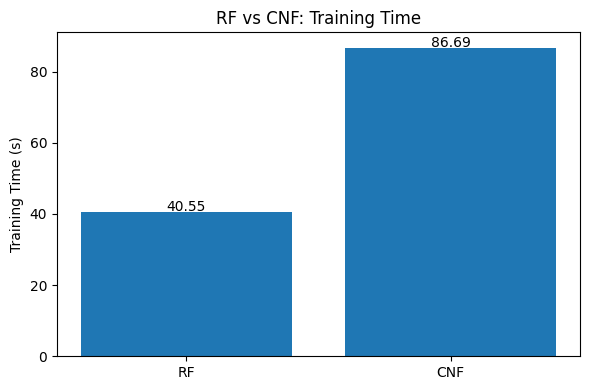

In [44]:
# 8. Main Execution
import time
import psutil
import os
import tracemalloc
import torch.cuda
if __name__ == "__main__":
    # Initialize models
    rf_model = RFNet()
    cnf_model = CNFNet()

    # Train models with timing and memory tracking
    print("Training Rectified Flow...")
    start_time = time.time()
    train_rf(rf_model, dataloader,epochs=3000, lr=1e-4)
    rf_time = time.time() - start_time
    # tracemalloc.stop() (no longer needed)
    rf_time = time.time() - start_time


    print("Training Continuous Normalizing Flow...")
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    train_cnf(cnf_model, target_data, epochs= 300)
    cnf_time = time.time() - start_time
    cnf_time = time.time() - start_time




    # Compare timing and memory usage
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    bars = ax.bar(['RF', 'CNF'], [rf_time, cnf_time])
    ax.set_ylabel('Training Time (s)')
    ax.set_title('RF vs CNF: Training Time')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{height:.2f}', ha='center')
    plt.tight_layout()
    plt.show()
    






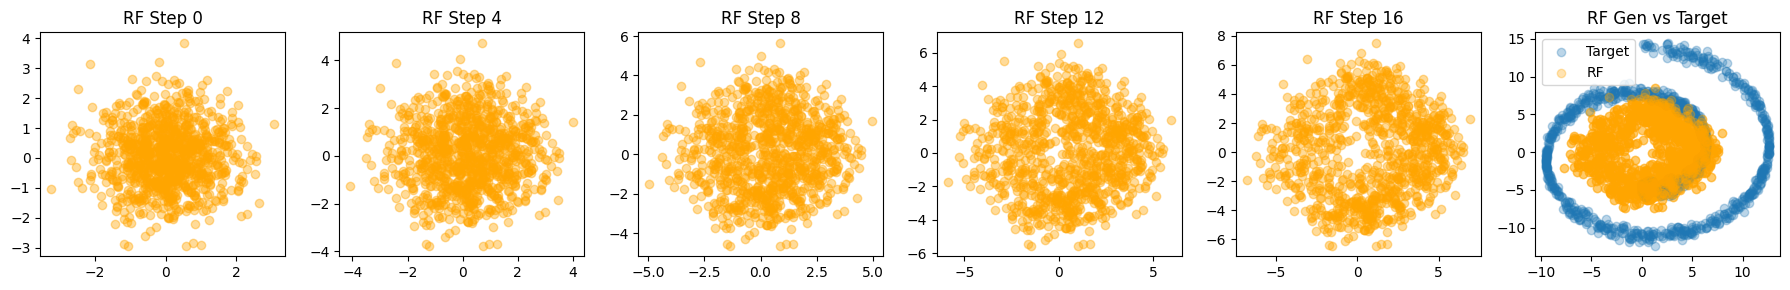

The frechet distance of RF model is:  21.888471278620912
The wasserstein distance of RF model is:  2.916400738671422


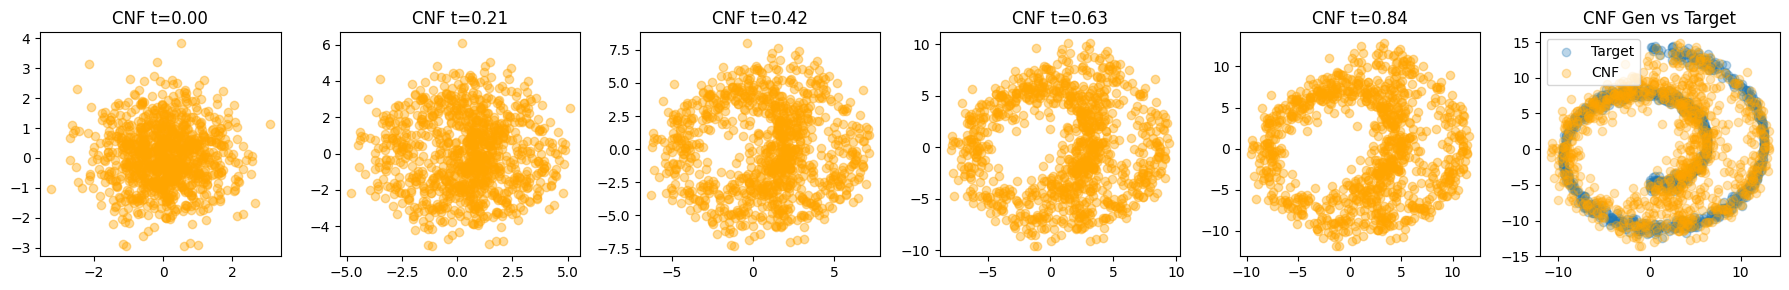

The frechet distance of CNF model is:  0.47170678293788626
The wasserstein distance of CNF model is:  0.5740697992681525


In [42]:

    # Visualize learned transformations
    visualize_rf(rf_model, source_data = source_data, target_np=target_np)
    visualize_cnf(cnf_model, source_data=source_data, target_np=target_np)